In [1]:
import sys
import os
import numpy as np
import json

from sklearn.model_selection import train_test_split
import pandas as pd

import tensorflow as tf
import keras.backend.tensorflow_backend as K
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Activation, LSTM, CuDNNGRU, CuDNNLSTM
from keras.layers import Dropout, Conv1D, MaxPooling1D, GlobalMaxPool1D
from keras.layers import Bidirectional, InputLayer

from keras import regularizers 
from keras.callbacks import EarlyStopping, ModelCheckpoint, ModelCheckpoint

Using TensorFlow backend.


In [2]:
tf.set_random_seed(201)
np.random.seed(201)

## 데이터 로드

In [3]:
DATA_IN_PATH = './data/word_dict/'
DATA_OUT_PATH = './data_out/'
#INPUT_TRAIN_DATA = 'input.npy'
#LABEL_TRAIN_DATA = 'label.npy'
#DATA_CONFIGS = 'data_configs.json'

INPUT_TRAIN_DATA = 'pos_input.npy'
LABEL_TRAIN_DATA = 'pos_label.npy'
DATA_CONFIGS = 'pos_data_configs.json'

input_data = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb'))
label_data = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r',  -1, "utf-8"))

In [4]:
TEST_SPLIT = 0.1
RND_SEED = 0
VOCAB_SIZE = prepro_configs['vocab_size']+1
EMB_SIZE = 128
BATCH_SIZE = 512
MAX_LEN = 200
max_features = 20000

In [5]:
train_input, eval_input, train_label, eval_label = train_test_split(input_data,
                                                                    label_data,
                                                                    test_size=TEST_SPLIT,
                                                                    random_state=RND_SEED)

In [6]:
train_input = sequence.pad_sequences(train_input, maxlen=MAX_LEN)
eval_input = sequence.pad_sequences(eval_input, maxlen=MAX_LEN)

## 모델 설정

In [7]:
from keras.engine import Layer, InputSpec
from keras.layers import Flatten
import tensorflow as tf

In [8]:
class KMaxPooling(Layer):
    """
    K-max pooling layer that extracts the k-highest activations from a sequence (2nd dimension).
    TensorFlow backend.
    """
    def __init__(self, k=1, sorted=True, **kwargs):
        super().__init__(**kwargs)
        self.input_spec = InputSpec(ndim=3)
        self.k = k
        self.sorted = sorted

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.k, input_shape[2])

    def call(self, inputs):
        # swap last two dimensions since top_k will be applied along the last dimension
        shifted_inputs = tf.transpose(inputs, [0, 2, 1])
        
        # extract top_k, returns two tensors [values, indices]
        top_k = tf.nn.top_k(shifted_inputs, k=self.k, sorted=self.sorted)[0]
        
        # return flattened output
        return tf.transpose(top_k, [0,2,1])

In [9]:
import keras
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, BatchNormalization, Activation, Add, MaxPooling1D, Dense, Flatten
from keras.engine.topology import get_source_inputs

In [10]:
def identity_block(inputs, filters, kernel_size=3, use_bias=False, shortcut=False):
    conv1 = Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='same')(inputs)
    bn1 = BatchNormalization()(conv1)
    relu = Activation('relu')(bn1)
    conv2 = Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='same')(relu)
    out = BatchNormalization()(conv2)
    if shortcut:
        out = Add()([out, inputs])
    return Activation('relu')(out)

In [11]:
def conv_block(inputs, filters, kernel_size=3, use_bias=False, shortcut=False, 
               pool_type='max', sorted=True, stage=1):
    conv1 = Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='same')(inputs)
    bn1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(bn1)

    conv2 = Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='same')(relu1)
    out = BatchNormalization()(conv2)

    if shortcut:
        residual = Conv1D(filters=filters, kernel_size=1, strides=2, name='shortcut_conv1d_%d' % stage)(inputs)
        residual = BatchNormalization(name='shortcut_batch_normalization_%d' % stage)(residual)
        out = downsample(out, pool_type=pool_type, sorted=sorted, stage=stage)
        out = Add()([out, residual])
        out = Activation('relu')(out)
    else:
        out = Activation('relu')(out)
        out = downsample(out, pool_type=pool_type, sorted=sorted, stage=stage)
    if pool_type is not None:
        out = Conv1D(filters=2*filters, kernel_size=1, strides=1, padding='same', name='1_1_conv_%d' % stage)(out)
        out = BatchNormalization(name='1_1_batch_normalization_%d' % stage)(out)
    return out

In [12]:
def downsample(inputs, pool_type='max', sorted=True, stage=1):
    if pool_type == 'max':
        out = MaxPooling1D(pool_size=3, strides=2, padding='same', name='pool_%d' % stage)(inputs)
    elif pool_type == 'k_max':
        k = int(inputs._keras_shape[1]/2)
        out = KMaxPooling(k=k, sorted=sorted, name='pool_%d' % stage)(inputs)
    elif pool_type == 'conv':
        out = Conv1D(filters=inputs._keras_shape[-1], kernel_size=3, strides=2, padding='same', name='pool_%d' % stage)(inputs)
        out = BatchNormalization()(out)
    elif pool_type is None:
        out = inputs
    else:
        raise ValueError('unsupported pooling type!')
    return out

In [13]:
def VDCNN(num_classes, depth=9, sequence_length=MAX_LEN, embedding_dim=16, 
          shortcut=False, pool_type='max', sorted=True, use_bias=False, input_tensor=None):
    if depth == 9:
        num_conv_blocks = (1, 1, 1, 1)
    elif depth == 17:
        num_conv_blocks = (2, 2, 2, 2)
    elif depth == 29:
        num_conv_blocks = (5, 5, 2, 2)
    elif depth == 49:
        num_conv_blocks = (8, 8, 5, 3)
    else:
        raise ValueError('unsupported depth for VDCNN.')

    inputs = Input(shape=(sequence_length, ), name='inputs')
    embedded_chars = Embedding(input_dim=sequence_length, output_dim=embedding_dim)(inputs)
    out = Conv1D(filters=64, kernel_size=3, strides=1, padding='same', name='temp_conv')(embedded_chars)

    # Convolutional Block 64
    for _ in range(num_conv_blocks[0] - 1):
        out = identity_block(out, filters=64, kernel_size=3, use_bias=use_bias, shortcut=shortcut)
    out = conv_block(out, filters=64, kernel_size=3, use_bias=use_bias, shortcut=shortcut, 
                     pool_type=pool_type, sorted=sorted, stage=1)

    # Convolutional Block 128
    for _ in range(num_conv_blocks[1] - 1):
        out = identity_block(out, filters=128, kernel_size=3, use_bias=use_bias, shortcut=shortcut)
    out = conv_block(out, filters=128, kernel_size=3, use_bias=use_bias, shortcut=shortcut, 
                     pool_type=pool_type, sorted=sorted, stage=2)

    # Convolutional Block 256
    for _ in range(num_conv_blocks[2] - 1):
        out = identity_block(out, filters=256, kernel_size=3, use_bias=use_bias, shortcut=shortcut)
    out = conv_block(out, filters=256, kernel_size=3, use_bias=use_bias, shortcut=shortcut, 
                     pool_type=pool_type, sorted=sorted, stage=3)

    # Convolutional Block 512
    for _ in range(num_conv_blocks[3] - 1):
        out = identity_block(out, filters=512, kernel_size=3, use_bias=use_bias, shortcut=shortcut)
    out = conv_block(out, filters=512, kernel_size=3, use_bias=use_bias, shortcut=False, 
                     pool_type=None, stage=4)

    # k-max pooling with k = 8
    out = KMaxPooling(k=8, sorted=True)(out)
    out = Flatten()(out)

    # Dense Layers
    out = Dense(2048, activation='relu')(out)
    out = Dense(2048, activation='relu')(out)
    out = Dense(num_classes, activation='softmax')(out)

    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = inputs

    # Create model.
    model = Model(inputs=inputs, outputs=out, name='VDCNN')
    return model

## 모델 생성

In [14]:
model = VDCNN(2, depth=49, shortcut=True, pool_type='max')
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "VDCNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 16)      3200        inputs[0][0]                     
__________________________________________________________________________________________________
temp_conv (Conv1D)              (None, 200, 64)      3136        embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 200, 64)      12352       temp_conv[0][0]                  
_____________________________________________________________________________________________

In [15]:
# 최선의 모델 model 저장
MODEL_PATH = './model/'
if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

model_full_path = MODEL_PATH + 'best_train_model.hdf5'

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min')
check_point = ModelCheckpoint(filepath=model_full_path, monitor='val_loss', verbose=1, save_best_only=True)

## 모델 학습 

In [17]:
with K.tf_ops.device('/device:GPU:0'):
    hist = model.fit(train_input, train_label, batch_size = BATCH_SIZE,
                     epochs = 10, validation_split = 0.2, callbacks=[early_stopping, check_point])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 6687 samples, validate on 1672 samples
Epoch 1/10
6687/6687 [==============================] - 18s 3ms/step - loss: 7.1557 - accuracy: 0.9252 - val_loss: 7.6767 - val_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 7.67666, saving model to ./model/best_train_model.hdf5
Epoch 2/10
6687/6687 [==============================] - 7s 1ms/step - loss: 7.6770 - accuracy: 1.0000 - val_loss: 7.6767 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 7.67666


## 모델 학습 시각화

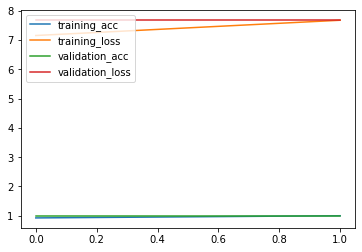

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['val_loss'])
plt.legend(['training_acc', 'training_loss','validation_acc', 'validation_loss'], loc = 'upper left')
plt.show()

## 모델 평가 

In [19]:
results = model.evaluate(eval_input, eval_label)
print('Test accuracy: ', results[1])

929/929 [==============================] - 1s 1ms/step
Test accuracy:  1.0


## 모델 사용